# Glutamate Metabolism Subsystem

Set the model environment


In [1]:
import cobra.test
import pandas as pd
import numpy as np
import pandas as pd
import escher
from escher import Builder
from cobra.sampling import sample
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 5000)
pd.set_option('display.width',1000)
pd.set_option('display.max_colwidth',None)
model = cobra.io.load_json_model('./e_coli_core.json') # Model must be in the same directory

Set parameter Username
Academic license - for non-commercial use only - expires 2022-10-10


The glutamate metabolism subsystem is often referred to as the nitrogen metabolism. Nitrogen enters the cell as either ammonium ion (nh4_c), or as a moiety within glutamine (glu-L_c) or glutamate (gln-L_c). The *E.coli* core model covers the pathways between 2-oxoglutarate, L-glutamate, and L-glutamine. The location of the glutamate metabolism subsystem reactions on the *E.coli* core map is shown in Figure 1.

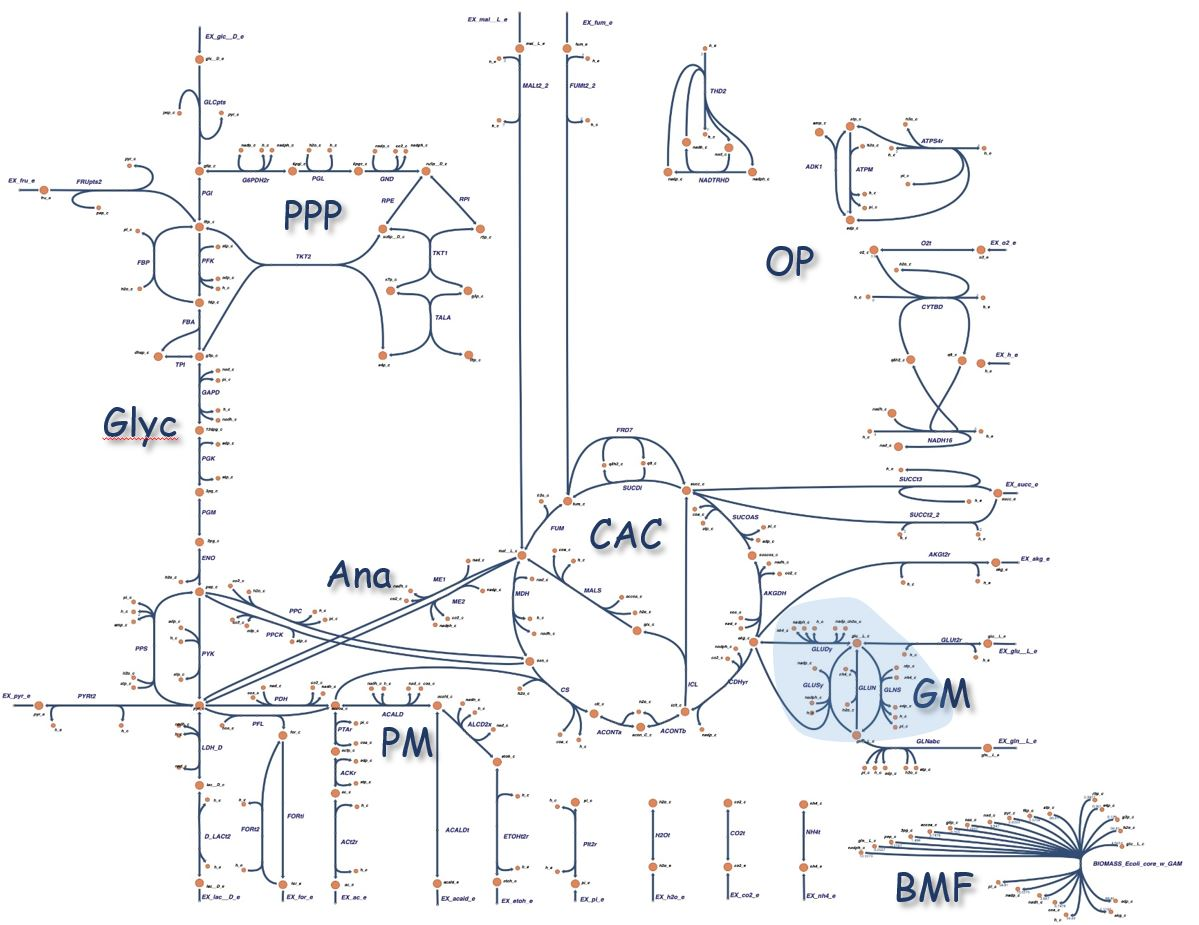

            Figure 1. The glutamate metabolism subsystem reactions highlighted in blue on the E.coli core map.

The reactions of the glutamate metabolism subsystem include: 

In [2]:
reaction_names = [r.name for r in model.reactions]
reaction_ids = [r.id for r in model.reactions]
reaction_formula = [r.reaction for r in model.reactions]
reaction_subsystem = [r.subsystem for r in model.reactions]
reactionList = {'Reaction ID': reaction_ids,
                'Reaction Name': reaction_names,
                'Reaction Formula': reaction_formula,
                'Reaction Subsystem': reaction_subsystem,
               }

df = pd.DataFrame(reactionList, columns= ['Reaction ID','Reaction Name','Reaction Formula','Reaction Subsystem'])
# Select the reactions associated with the desired subsystem
SSindex = []
for i in range(len(reaction_subsystem)):
    if reaction_subsystem[i] == 'Glutamate Metabolism':
        SSindex.append(i)
df.loc[SSindex]

,Reaction ID,Reaction Name,Reaction Formula,Reaction Subsystem
74,GLNS,Glutamine synthetase,atp_c + glu__L_c + nh4_c --> adp_c + gln__L_c + h_c + pi_c,Glutamate Metabolism
76,GLUDy,Glutamate dehydrogenase (NADP),glu__L_c + h2o_c + nadp_c <=> akg_c + h_c + nadph_c + nh4_c,Glutamate Metabolism
77,GLUN,Glutaminase,gln__L_c + h2o_c --> glu__L_c + nh4_c,Glutamate Metabolism
78,GLUSy,Glutamate synthase (NADPH),akg_c + gln__L_c + h_c + nadph_c --> 2.0 glu__L_c + nadp_c,Glutamate Metabolism


The reactions, GRPA relationships, and precursors for this section on the nitrogen metabolism are shown in the Figure 2 below.

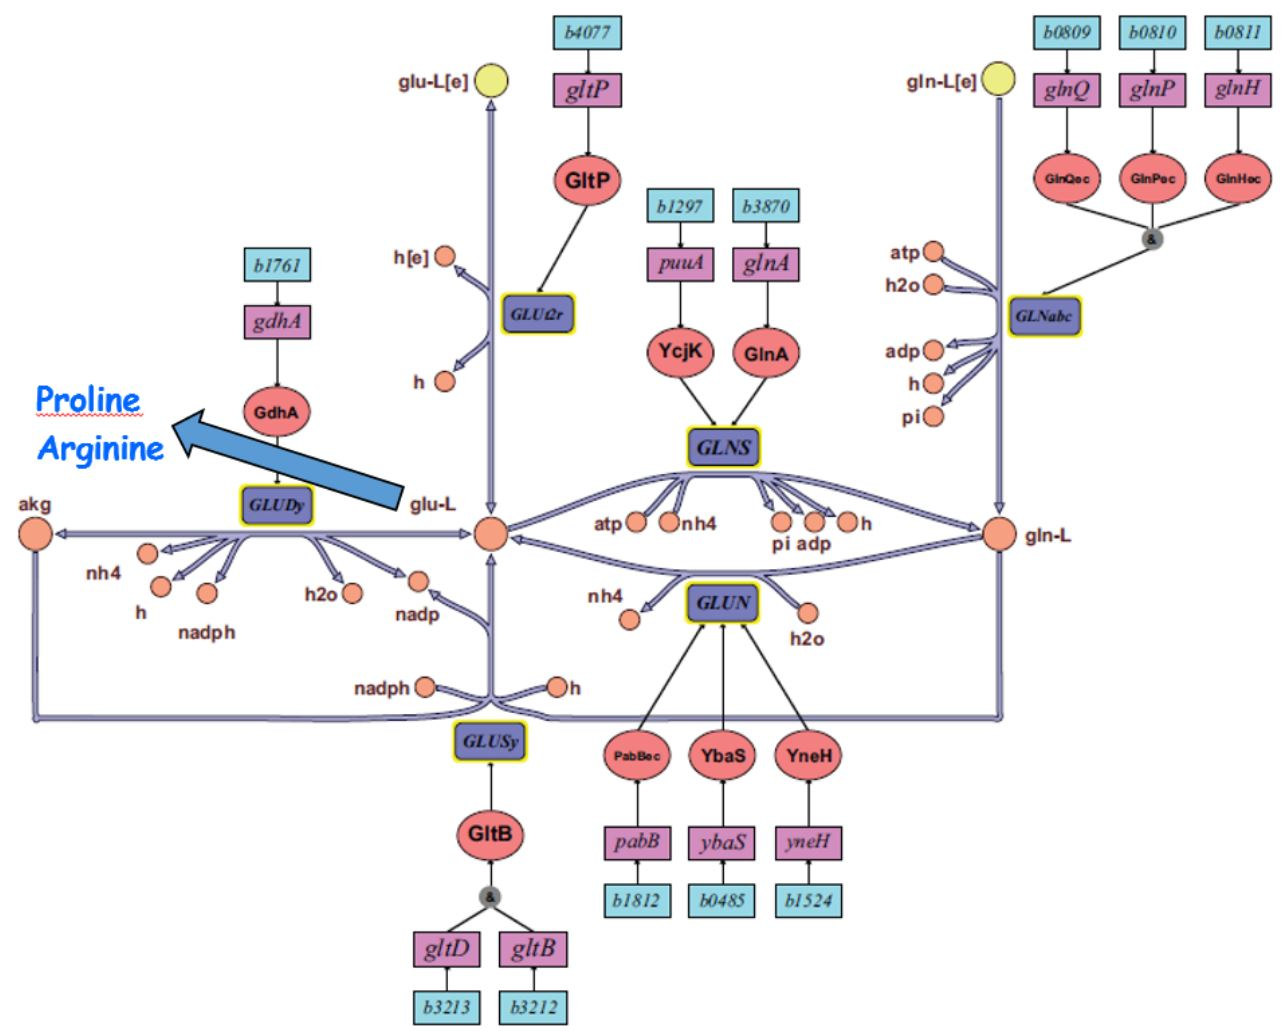

            Figure 2. Reactions GRPA relationships, and precursors associated with the nitrogen metabolism [1].

Note that the precursors supported by nitrogen metaboism are proline and arginine. 

In this simple model, one of the potential sources of nitrogen is through ammonium which is transported into the cell through a transporter (NH4t). Within the cell there are only two reactions (GLNS, GLUDy) that can also assimulate the needed nitrogen into the cell. Let's begin by looking at the glutamate subsystem reaction in a simulation with glucose as the carbon source.

In [3]:
model = cobra.io.load_json_model('./e_coli_core.json')
# Set the inputs
model.reactions.EX_o2_e.lower_bound = -0 # Aerobic condition
model.reactions.EX_glc__D_e.lower_bound = -10
# Optimize
Glucose_aerobic_flux = model.optimize()
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,0.3782,1,0.63%
glc__D_e,EX_glc__D_e,10,6,99.37%
h2o_e,EX_h2o_e,7.116,0,0.00%
nh4_e,EX_nh4_e,1.154,0,0.00%
pi_e,EX_pi_e,0.7786,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
ac_e,EX_ac_e,-8.504,2,33.11%
etoh_e,EX_etoh_e,-8.279,2,32.23%
for_e,EX_for_e,-17.8,1,34.66%
h_e,EX_h_e,-30.55,0,0.00%


The active reactions include

In [4]:
nz = Glucose_aerobic_flux.fluxes
nz = nz.replace(0, np.nan)
nz = nz.dropna(how='all', axis=0)
nz

PFK                          9.789459
PFL                         17.804674
PGI                          9.956609
PGK                        -19.437336
ACALD                       -8.279455
PGM                        -19.120689
PIt2r                        0.778644
ALCD2x                      -8.279455
ACKr                        -8.503585
PPC                          0.606541
ACONTa                       0.228363
ACONTb                       0.228363
ATPM                         8.390000
ACt2r                       -8.503585
ATPS4r                      -5.452053
PTAr                         8.503585
PYK                          8.404273
BIOMASS_Ecoli_core_w_GAM     0.211663
CO2t                         0.378178
RPE                         -0.152143
CS                           0.228363
RPI                         -0.152143
ENO                         19.120689
ETOHt2r                     -8.279455
TALA                        -0.037867
THD2                         3.629194
TKT1        

In [5]:
builder = Builder(
    map_name='e_coli_core.Core metabolism', 
    model_name='e_coli_core', 
)
builder

Builder()

In [6]:
builder.reaction_data = Glucose_aerobic_flux.fluxes

Let's begin by exploring the produceer and consumer of nh4_c

In [7]:
model.metabolites.nh4_c.summary()

Percent,Flux,Reaction,Definition
100.00%,1.154,NH4t,nh4_e <=> nh4_c
Percent,Flux,Reaction,Definition
4.69%,-0.05412,GLNS,atp_c + glu__L_c + nh4_c --> adp_c + gln__L_c + h_c + pi_c
95.31%,-1.1,GLUDy,glu__L_c + h2o_c + nadp_c <=> akg_c + h_c + nadph_c + nh4_c


In this situation, the nh4_c is produced by the uptake of nh4_e through NH4t. It is consumed by both GLNs and GLUDy. Now let's look at where these to reaction distribute the flux. Looking at the reaction equation for GLUDy operates in a reverse direction converting nadph_c and 2-Oxoglutarate (akg_g) produced in the TCA cycle into glutamate (glu__L_c) and nadp_c, while GLNS uses nh4_c is to convert glutmate (glu__L_c) into glutamine (gln__L_c).

Now let's look at how both glutamate and glutamine are consumed. First glutmate,

In [8]:
model.metabolites.glu__L_c.summary()

Percent,Flux,Reaction,Definition
100.00%,1.1,GLUDy,glu__L_c + h2o_c + nadp_c <=> akg_c + h_c + nadph_c + nh4_c
Percent,Flux,Reaction,Definition
95.08%,-1.046,BIOMASS_Ecoli_core_w_GAM,1.496 3pg_c + 3.7478 accoa_c + 59.81 atp_c + 0.361 e4p_c + 0.0709 f6p_c + 0.129 g3p_c + 0.205 g6p_c + 0.2557 gln__L_c + 4.9414 glu__L_c + 59.81 h2o_c + 3.547 nad_c + 13.0279 nadph_c + 1.7867 oaa_c + 0.5191 pep_c + 2.8328 pyr_c + 0.8977 r5p_c --> 59.81 adp_c + 4.1182 akg_c + 3.7478 coa_c + 59.81 h_c + 3.547 nadh_c + 13.0279 nadp_c + 59.81 pi_c
4.92%,-0.05412,GLNS,atp_c + glu__L_c + nh4_c --> adp_c + gln__L_c + h_c + pi_c


The produced glutamate is used to produce glutamine and provide the biomass function with the resources to simulate the operation of the cell. Glutamine, on the other hand is exclusively consumed by the biomass function.

In [9]:
model.metabolites.gln__L_c.summary()

Percent,Flux,Reaction,Definition
100.00%,0.05412,GLNS,atp_c + glu__L_c + nh4_c --> adp_c + gln__L_c + h_c + pi_c
Percent,Flux,Reaction,Definition
100.00%,-0.05412,BIOMASS_Ecoli_core_w_GAM,1.496 3pg_c + 3.7478 accoa_c + 59.81 atp_c + 0.361 e4p_c + 0.0709 f6p_c + 0.129 g3p_c + 0.205 g6p_c + 0.2557 gln__L_c + 4.9414 glu__L_c + 59.81 h2o_c + 3.547 nad_c + 13.0279 nadph_c + 1.7867 oaa_c + 0.5191 pep_c + 2.8328 pyr_c + 0.8977 r5p_c --> 59.81 adp_c + 4.1182 akg_c + 3.7478 coa_c + 59.81 h_c + 3.547 nadh_c + 13.0279 nadp_c + 59.81 pi_c


Nitrogen can also enter the cell through the uptake of glutamate or glutamine. As a reminder, the default settings for the core model do not allow any amino acids to enter the core model. To change this you would need to change the lower bounmds to allow either glutamate or gluamine uptake capability.

Both glutamate and glutamine can serve as both carbon and nitrogen sources under aerobic conditions. An example of glutamate serving as both carbon and nitrogen source is shown below. 

In [10]:
model2 = cobra.io.load_json_model('./e_coli_core.json')
# Set the inputs
model2.reactions.EX_o2_e.lower_bound = -30 # Aerobic condition
model2.reactions.EX_glc__D_e.lower_bound = -0
model2.reactions.EX_nh4_e.lower_bound = -0 # By default the uptake of nh4_e is allowed; must be set to zero
model2.reactions.EX_glu__L_e.lower_bound = -20
# Optimize
Glutamate_aerobic_flux = model2.optimize()
model2.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
glu__L_e,EX_glu__L_e,20,5,100.00%
h_e,EX_h_e,7.075,0,0.00%
o2_e,EX_o2_e,30,0,0.00%
pi_e,EX_pi_e,3.983,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
ac_e,EX_ac_e,-4.711,2,17.47%
co2_e,EX_co2_e,-38.01,1,70.49%
for_e,EX_for_e,-6.492,1,12.04%
h2o_e,EX_h2o_e,-5.893,0,0.00%
nh4_e,EX_nh4_e,-14.1,0,0.00%


The Escher map

In [11]:
builder2 = Builder(
    map_name='e_coli_core.Core metabolism', 
    model_name='e_coli_core', 
)
builder2

Builder()

In [12]:
builder2.reaction_data = Glutamate_aerobic_flux.fluxes

Since the normal source of nadh[c] from the glycolysis pathway is not availabe during gluconeogenesis, let's explore where the nadh[c] is produced and consumed.

In [13]:
model2.metabolites.nadh_c.summary()

Percent,Flux,Reaction,Definition
42.75%,18.83,AKGDH,akg_c + coa_c + nad_c --> co2_c + nadh_c + succoa_c
8.72%,3.841,BIOMASS_Ecoli_core_w_GAM,1.496 3pg_c + 3.7478 accoa_c + 59.81 atp_c + 0.361 e4p_c + 0.0709 f6p_c + 0.129 g3p_c + 0.205 g6p_c + 0.2557 gln__L_c + 4.9414 glu__L_c + 59.81 h2o_c + 3.547 nad_c + 13.0279 nadph_c + 1.7867 oaa_c + 0.5191 pep_c + 2.8328 pyr_c + 0.8977 r5p_c --> 59.81 adp_c + 4.1182 akg_c + 3.7478 coa_c + 59.81 h_c + 3.547 nadh_c + 13.0279 nadp_c + 59.81 pi_c
15.88%,6.995,MDH,mal__L_c + nad_c <=> h_c + nadh_c + oaa_c
26.87%,11.84,ME1,mal__L_c + nad_c --> co2_c + nadh_c + pyr_c
0.60%,0.2655,NADTRHD,nad_c + nadph_c --> nadh_c + nadp_c
5.17%,2.277,PDH,coa_c + nad_c + pyr_c --> accoa_c + co2_c + nadh_c
Percent,Flux,Reaction,Definition
6.54%,-2.878,GAPD,g3p_c + nad_c + pi_c <=> 13dpg_c + h_c + nadh_c
93.46%,-41.17,NADH16,4.0 h_c + nadh_c + q8_c --> 3.0 h_e + nad_c + q8h2_c


We can see here that there are many sources of nadh_c production including: AKGDH and MDH from the reductive pathways of the TCA cycle, the anapleurotic reaction ME1, PDH from the fermentation metabolism, and even with the oxidatative phosphorylation reactions where excess nadph_c is converted to nadh_c. The consumers are primarily NADH16 where it provides the reducing power necessary for the electron transport chain and GAPD which is required for the operaton of gluconeogenesis.

# References

1. Orth, Fleming, and Palsson (2010), EcoSal Chapter 10.2.1 - Reconstruction and Use of Microbial Metabolic Networks: the Core Escherichia coli Metabolic Model as an Educational Guide

